In [39]:
%load_ext autoreload
%autoreload 2

# Imports
import copy
import tensorflow as tf
import recommender
from recommender import FactorizationRecommender, BPRRecommender
from matrix import ReportTechniqueMatrix
from matrix_builder import ReportTechniqueMatrixBuilder
import random
import math
import importlib
import pandas as pd
import numpy as np
import sklearn.manifold
import matplotlib.pyplot as plt
from utils import get_mitre_technique_ids_to_names
import copy

tf.config.run_functions_eagerly(True)

assert tf.executing_eagerly()

importlib.reload(recommender)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module 'recommender' from '/Users/mjturner/code/technique-inference-engine/models/recommender/__init__.py'>

In [102]:
class TechniqueInferenceEngine:
    """A technique inference engine.

    The technique inference engine predicts, given a bag of MITRE
    ATT&CK techniques, the next most likely techniques that would be part
    of that report, given the report dataset provided.
    """

    # Abstraction function:
    #	AF(training_data, test_data, model, enterprise_attack_filepath) =
    #       a technique inference engine to be trained using model on
    #       training_data and evaluated on test_data
    #       according to the MITRE ATT&CK framework specified in enterprise_attack_filepath.
    # Rep invariant:
    # - training_data.shape == test_data.shape
    # - model is not None
    # - len(enterprise_attack_filepath) >= 0
    # Safety from rep exposure:
    # - all attributes are private
    # - training_data and test_data are immutable
    # - model is deep copied and never returned

    def __init__(self, training_data: ReportTechniqueMatrix, test_data: ReportTechniqueMatrix, model: FactorizationRecommender, enterprise_attack_filepath: str):
        """Initializes a TechniqueInferenceEngine object.

        Args:
            training_data: the data on which to train the model.
            test_data: the data on which to evaluate the model's performance.
            model: the model to train.
            enterprise_attack_filepath: filepath for the MITRE enterprise ATT&CK json information.
        """
        self._enterprise_attack_filepath = enterprise_attack_filepath

        self._training_data = training_data
        self._test_data = test_data
        self._model = copy.deepcopy(model)

        self._checkrep()

    def _checkrep(self):
        """Asserts the rep invariant."""
        # - training_data.shape == test_data.shape
        assert self._training_data.shape == self._test_data.shape
        # - model is not None
        assert self._model is not None
        # - len(enterprise_attack_filepath) >= 0
        assert len(self._enterprise_attack_filepath) >= 0

    def _add_technique_name_to_dataframe(self, data: pd.DataFrame):
        """Adds a technique name column to the dataframe.

        Args:
            data: data indexed by technique id.

        Mutates:
            data to add a column titled "technique_name"
        """
        all_mitre_technique_ids_to_names = get_mitre_technique_ids_to_names(self._enterprise_attack_filepath)
        data.loc[:,"technique_name"] = data.apply(lambda row: all_mitre_technique_ids_to_names.get(row.name), axis=1)

    def fit(self, **kwargs) -> float:
        """Fit the model to the data.

        Args:
            learning_rate: learning rate for the optimizer.
            num_iterations: number of iterations for the optimizer.
            regularization_coefficient: coefficient for the regularization term, which
                is the sum of the average squared magnitude of each of both the
                technique and report embeddings.
            gravity_coefficient: coefficient for the gravity term, which is the average
                of the squared entries of the prediction matrix, or alternatively,
                the squared Frobenius norm of the prediction matrix P divided by the number
                of entries in P.  Note that this is proportional to penalizing the sum
                of the squares of the singular values of P.

        Returns:
            The MSE of the prediction matrix, as determined by the test set.
        """
        # train
        self._model.fit(self._training_data.to_sparse_tensor(), **kwargs)

        mean_squared_error = self._model.evaluate(self._test_data.to_sparse_tensor())

        self._checkrep()
        return mean_squared_error

    def recall(self, k: int=10) -> float:
        """Calculates the recall of the model.

        Recall is defined as the average fraction of items in the test set which appear
        in the top-k predictions.  If k < the number of items in the test set for a
        particular user, then the maximum recall is 1.0.

        Mathematically, it is defined as
        recall@k = (1\m) \sum_u (\sum_{i=1}^k [[pred_i in test set]] / k)

        Args:
            k: the number of predictions to get from the model.

        Returns:
            The computed recall for the top k predictions.
        """
        num_users = self._training_data.m

        # get a matrix with a 1 in the top 10 spots
        # find overlap with test set
        # if 1 in both, then predicted in top k
        # min to get lowest rank in group, aka less than k
        top_k_predictions = self.predict().rank(axis=1, method="first", ascending=False) <= k
        assert self._training_data.m, 1 == top_k_predictions.shape
        test_items_in_top_k = (self._test_data.to_pandas() > 0) & top_k_predictions
        num_recalled_predictions = test_items_in_top_k.sum().sum()

        # sum number of predictions in top k, divide by k
        return (1/num_users) * num_recalled_predictions / k

    def normalized_discounted_cumulative_gain(self, k: int=10) -> float:
        """Computes the Normalized Discounted Cumulative Gain (NDCG) on the test set.

        NDCG measures the goodness of a ranking based on the relative ordering of
        test set entries in the top-k predictions of the model.  Test set predictions
        that appear near the top of the top-k predictions (in descending order)
        for the model contribute more to NDCG than predictions which are ranked lower.
        NDCG ranges from 0 to 1, where 1 is a perfect ranking.

        Mathematically, NDCG is defined as
        NDCG@K = DCG@K / IDCG@K
        DCG@K = (1/m) \sum_u \sum_{i=1}^k (2^[[pred_i in test set]] - 1)/(log_2 (i+1))
        IDCG@K is a normalization constant corresponding to the maximum possible value
            of DCG@K

        Args:
            k: the number of predictions to get from the model.

        Returns:
            NDCG computed on the top k predictions.
        """
        test_set_size = self._test_data.to_pandas().sum(axis=1).astype("int")
        assert (self._training_data.m, ) == test_set_size.shape
        def max_idcg(k) -> float:
            return sum(math.log2(i+1) for i in range(1, k+1))

        user_idcg = test_set_size.apply(max_idcg)
        idcg = user_idcg.sum() / self._training_data.m

        prediction_ranking = self.predict().rank(axis=1, method="first", ascending=False)
        assert self._training_data.m, 1 == prediction_ranking.shape

        # numerator: 1 if test set is in prediction, 0 otherwise
        numerator = np.logical_and((prediction_ranking <= k).to_numpy(), self._test_data.to_numpy())

        # denominator: log_2 of ranking + 1
        denominator = np.log2(prediction_ranking.to_numpy() + 1)

        divide = np.divide(numerator, denominator)

        dcg = (1 / self._training_data.m) * np.sum(divide)

        return dcg / idcg

    def predict(self) -> pd.DataFrame:
        """Obtains model predictions.

        For each report, predicts a value for every technique based on the likelihood
        that technique should be featured in the report.  A higher predicted value for
        technique a than technique b represents an inference that technique a is more
        likely in the report than technique b.

        Returns:
            A dataframe with the same shape, index, and columns as training_data and test_data
                containing the predictions values for each report and technique combination.
        """
        predictions = self._model.predict()

        predictions_dataframe = pd.DataFrame(predictions, index=self._training_data.report_ids, columns=self._training_data.technique_ids)

        self._checkrep()
        return predictions_dataframe

    def view_prediction_performance_table_for_report(self, report_id: int) -> pd.DataFrame:
        """Gets the training data, test data, and predictions for a particular report.

        Args:
            report_id: identifier for the report.  Must be in the training_data and
                test_data.

        Returns:
            A length len(training_data) dataframe indexed by technique id containing the following columns:
                - predictions, the predicted value for that echnique
                - training_data: 1 if technique was present in the input, 0 otherwise
                - test_data: all 0's since no test data for cold start predictions
                - technique_name: the technique name for the identifying technique in the index
        """
        report_data = pd.DataFrame(
            {
                "predictions": self.predict().loc[report_id],
                "training_data": self._training_data.to_pandas().loc[report_id],
                "test_data": self._test_data.to_pandas().loc[report_id],
            }
        )

        # add name for convenience
        self._add_technique_name_to_dataframe(report_data)

        self._checkrep()
        return report_data

    def predict_for_new_report(self, techniques: frozenset[str], **kwargs) -> pd.DataFrame:
        """Predicts for a new, yet-unseen report.

        Args:
            techniques: an iterable of MITRE technique identifiers involved
                in the new report.

        Returns:
            A length n dataframe indexed by technique id containing the following columns:
                - predictions, the predicted value for that echnique
                - training_data: 1 if technique was present in the input, 0 otherwise
                - test_data: all 0's since no test data for cold start predictions
                - technique_name: the technique name for the identifying technique in the index
        """
        # need to turn into the embeddings in the original matrix
        all_technique_ids = self._training_data.technique_ids
        technique_ids_to_indices = {all_technique_ids[i]: i for i in range(len(all_technique_ids))}

        technique_indices = list(set(technique_ids_to_indices[technique] for technique in techniques))
        technique_indices.sort()
        technique_indices_2d = np.expand_dims(np.array(technique_indices), axis=1)

        # 1 for each index
        values = np.ones((len(technique_indices),))
        n = self._training_data.n

        technique_tensor = tf.SparseTensor(
            indices=technique_indices_2d, values=values, dense_shape=(n,)
        )

        predictions = self._model.predict_new_entity(technique_tensor, **kwargs)

        training_indices_dense = np.zeros(len(predictions))
        training_indices_dense[technique_indices] = 1
        result_dataframe = pd.DataFrame(
            {
                "predictions": predictions,
                "training_data": training_indices_dense,
                "test_data": np.zeros(len(predictions)),
            },
            index=all_technique_ids
        )

        self._add_technique_name_to_dataframe(result_dataframe)

        self._checkrep()
        return result_dataframe

    def get_U(self) -> np.ndarray:
        """Get the item embeddings of the model."""
        return self._model.U

    def get_V(self) -> np.ndarray:
        """Get the user embeddings of the model."""
        return self._model.V


In [104]:
# data locations
dataset_filepath = "../data/combined_dataset_full_frequency.json"
enterprise_attack_filepath = "../enterprise-attack.json"

# hyperparameters
test_ratio = 0.2
learning_rate = 20
num_iterations = 1000
regularization_coefficient = 0.3
gravity_coefficient = 0.2
embedding_dimension = 20
k = 20

# make data
data_builder = ReportTechniqueMatrixBuilder(
    combined_dataset_filepath=dataset_filepath,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
data = data_builder.build()
# split into training and test data
train_indices = frozenset(random.sample(data.indices, k=math.floor((1-test_ratio) * len(data.indices))))
test_indices = frozenset(data.indices).difference(train_indices)
training_data = data.mask(train_indices)
test_data = data.mask(test_indices)

model = FactorizationRecommender(m=training_data.m, n=training_data.n, k=embedding_dimension)

tie = TechniqueInferenceEngine(
    training_data=training_data,
    test_data=test_data,
    model=model,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
mse = tie.fit(
    learning_rate=learning_rate,
    num_iterations=num_iterations,
    regularization_coefficient=regularization_coefficient,
    gravity_coefficient=gravity_coefficient,
)
print("Mean Squared Error", mse)
recall = tie.recall(k=k)
print("Recall", recall)
ndcg = tie.normalized_discounted_cumulative_gain(k=k)
print("Normalized Discounted Cumulative Gain", ndcg)

Mean Squared Error 0.1633085
Recall 0.023602682848930055
Normalized Discounted Cumulative Gain 0.07185941471101275


In [105]:
# data locations
dataset_filepath = "../data/combined_dataset_full_frequency.json"
enterprise_attack_filepath = "../enterprise-attack.json"

# hyperparameters
test_ratio = 0.2
learning_rate = 0.01
num_iterations = 100000
w_regularization = 0.0001
v_i_regularization = 0.0001
v_j_regularization = 0.0001
embedding_dimension = 10

model = BPRRecommender(m=training_data.m, n=training_data.n, k=embedding_dimension)

tie = TechniqueInferenceEngine(
    training_data=training_data,
    test_data=test_data,
    model=model,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
mse = tie.fit(
    learning_rate=learning_rate,
    num_iterations=num_iterations,
    w_regularization=w_regularization,
    v_i_regularization=v_i_regularization,
    v_j_regularization=v_j_regularization,
)
print("Mean Squared Error", mse)
recall = tie.recall(k=20)
print("Recall", recall)
ndcg = tie.normalized_discounted_cumulative_gain(k=k)
print("Normalized Discounted Cumulative Gain", ndcg)

Mean Squared Error 1.0769348761089634
Recall 0.0019243053337591825
Normalized Discounted Cumulative Gain 0.004793875412269273


In [32]:
# COLD START PREDICTOR
# use one of the below sets of techniques or use your own!

# training_techniques = set(['T1021.004', 'T1572', 'T1083', 'T1570', 'T1571', 'T1105', 'T1003.001',
#     'T1005', 'T1056.001', 'T1140', 'T1555.003', 'T1569.002', 'T1113',
#     'T1018', 'T1112'
# ])
oilrig_techniques = {
    "T1047", "T1059.005", "T1124", "T1082",
    "T1497.001", "T1053.005", "T1027", "T1105",
    "T1070.004", "T1059.003", "T1071.001"}
oilrig_adversary_emulation_plan_techniques = {"T1082", "T1033", "T1016", "T1087.002", "T1069.002", "T1021", "T1087.001", "T1069.001", "T1049", "T1057", "T1007", "T1012", "T1018", "T1555.004", "T1041", "T1105", "T1505.003", "T1003.001", "T1070.004", "T1572", "T1021.001", "T1569.002", "T1083", "T1048.003"}
# solarigate_techniques = set(["T1087", "T1087.002", "T1098.001", "T1098.002", "T1098.003", "T1098.005",
#     "T1583.001", "T1071.001", "T1560.001", "T1059.001", "T1059.003", "T1059.005",
#     "T1584.001", "T1555", "T1555.003", "T1213", "T1213.003", "T1005", "T1074.002",
#     "T1140", "T1587.001", "T1484.002", "T1482", "T1568", "T1114.002", "T1546.003",
#     "T1048.002", "T1190", "T1133", "T1083", "T1606.001", "T1606.002", "T1589.001",
#     "T1562.001", "T1562.002", "T1562.004", "T1070", "T1070.004", "T1070.006", "T1070.008",
#     "T1105", "T1036", "T1036.004", "T1036.005", "T1003.006", "T1069", "T1069.002",
#     "T1057", "T1090.001", "T1021.001", "T1021.002", "T1021.006", "T1018", "T1053.005",
#     "T1558.003", "T1539", "T1559.002", "T1195.002", "T1218.011", "T1082", "T1016.001",
#     "T1199", "T1552.004", "T1550", "T1550.001", "T1550.004", "T1078",
#     "T1078.002", "T1078.003", "T1078.004", "T1047",
# ])

factorization_kwargs = {
    "learning_rate": 0.5,
    "num_iterations": 10,
    "regularization_coefficient": 0.1,
    "gravity_coefficient": 1,
}

bpr_kwargs = {
    "learning_rate": 0.01,
    "num_iterations": 1000,
    "w_regularization": 0.001,
}

new_report_predictions = tie.predict_for_new_report(
    oilrig_techniques,
    **bpr_kwargs,
)

print(new_report_predictions.sort_values(by="predictions", ascending=False).head(10))

           predictions  training_data  test_data  \
T1568.003     1.388196            0.0        0.0   
T1119         1.120555            0.0        0.0   
T1596.005     1.091378            0.0        0.0   
T1565.002     1.053923            0.0        0.0   
T1552.003     1.042233            0.0        0.0   
T1134.004     0.967330            0.0        0.0   
T1564.008     0.959869            0.0        0.0   
T1010         0.919087            0.0        0.0   
T1586.002     0.905039            0.0        0.0   
T1132         0.902563            0.0        0.0   

                          technique_name  
T1568.003                DNS Calculation  
T1119               Automated Collection  
T1596.005                 Scan Databases  
T1565.002  Transmitted Data Manipulation  
T1552.003                   Bash History  
T1134.004            Parent PID Spoofing  
T1564.008             Email Hiding Rules  
T1010       Application Window Discovery  
T1586.002                 Email Accounts

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6262 samples in 0.002s...
[t-SNE] Computed neighbors for 6262 samples in 0.409s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6262
[t-SNE] Computed conditional probabilities for sample 2000 / 6262
[t-SNE] Computed conditional probabilities for sample 3000 / 6262
[t-SNE] Computed conditional probabilities for sample 4000 / 6262
[t-SNE] Computed conditional probabilities for sample 5000 / 6262
[t-SNE] Computed conditional probabilities for sample 6000 / 6262
[t-SNE] Computed conditional probabilities for sample 6262 / 6262
[t-SNE] Mean sigma: 0.271491
[t-SNE] KL divergence after 50 iterations with early exaggeration: 91.152000
[t-SNE] KL divergence after 10000 iterations: 3.149590


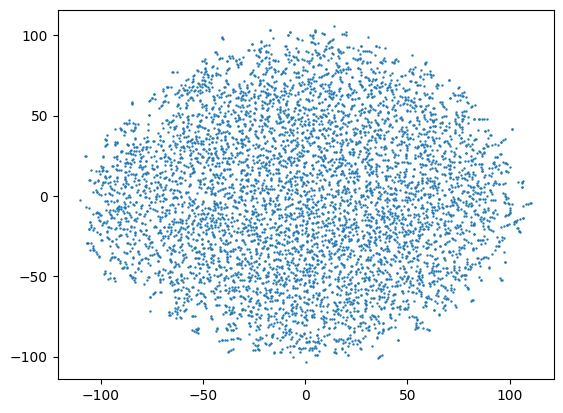

In [34]:
def make_tsne_embeddings(embeddings: np.ndarray) -> tuple[np.array, np.array]:
    """Create 2D representation of embeddings using t-SNE.

    Args:
        embeddings: an mxk array of m embeddings in k-dimensional space.

    Returns:
        A tuple of the form (x_1, x_2) where x_1 and x_2 are length m
        such that (x_1[i], x_2[i]) is the 2-dimensional point cotnaining the 2-dimensional
        repsresentation for embeddings[i, :].
    """
    tsne = sklearn.manifold.TSNE(
        n_components=2,
        perplexity=30,
        learning_rate="auto",
        # metric='cosine',
        # early_exaggeration=10.0,
        init='pca',
        verbose=True,
        n_iter=10000,
    )

    V_proj = tsne.fit_transform(embeddings)
    x = V_proj[:, 0]
    y = V_proj[:, 1]

    return x, y

U = tie.get_U()
x_1, x_2 = make_tsne_embeddings(U)

plt.scatter(x_1, x_2, s=0.5)
plt.show()